## 2. Regression Project: Linear Regression  ##



### 2.1 Airbnb listings in Madrid  ###
* **Dataset:** http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2021-09-10/data/listings.csv.gz
* **Description:** detailed data for Airbnb listings in Madrid, compiled on *10.09.2021* by **Inside Airbnb**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
# Look at the dataset: 18,909 listings with 74 features
listings = pd.read_csv('listings.csv')
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18909 entries, 0 to 18908
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            18909 non-null  int64  
 1   listing_url                                   18909 non-null  object 
 2   scrape_id                                     18909 non-null  int64  
 3   last_scraped                                  18909 non-null  object 
 4   name                                          18906 non-null  object 
 5   description                                   17854 non-null  object 
 6   neighborhood_overview                         10997 non-null  object 
 7   picture_url                                   18908 non-null  object 
 8   host_id                                       18909 non-null  int64  
 9   host_url                                      18909 non-null 

### 2.2 Data subset ###
* Get rid of listings without a verified host:

In [ ]:
# Keep listings with verified host identity (13,818 out of 18,883)
listings_ver = listings.copy()[listings.host_identity_verified=='t']
listings_ver.host_identity_verified.value_counts()

t    13818
Name: host_identity_verified, dtype: int64

* Continue with the following columns:

In [ ]:
# 2 date variables
date_vars = ['last_scraped', 
             'host_since']

# 13 numerical variables
num_vars = ['host_id',
            'accommodates',
            'bedrooms',
            'price',
            'minimum_nights', 
            'availability_30',
            'availability_60',
            'availability_90',
            'availability_365',
            'number_of_reviews', 
            'number_of_reviews_ltm',
            'number_of_reviews_l30d',
            'calculated_host_listings_count']

# 5 categorical variables
cat_vars = ['host_is_superhost',
            'neighbourhood_group_cleansed', 
            'room_type',
            'instant_bookable']

In [ ]:
columns = date_vars + num_vars + cat_vars
df = listings_ver.copy()[columns]

#### Features ####
* **'accommodates':** the maximum capacity of the listing.
* **'calculated_host_listings_count':** the total count of host's listings (all four types of places).
* **'neighbourhood_group_cleansed':** compiled by comparing the listing's geographic coordinates ('latitude' & 'longitude') with a city's definition of neighbourhoods. 
* **'room_type':** hosts offer four types of places: 'Entire home/apt', 'Private room', 'Shared room', and Hotel room.

### 2.3 Variable data types ###

In [ ]:
df.dtypes

last_scraped                       object
host_since                         object
host_id                             int64
accommodates                        int64
bedrooms                          float64
price                              object
minimum_nights                      int64
availability_30                     int64
availability_60                     int64
availability_90                     int64
availability_365                    int64
number_of_reviews                   int64
number_of_reviews_ltm               int64
number_of_reviews_l30d              int64
calculated_host_listings_count      int64
host_is_superhost                  object
neighbourhood_group_cleansed       object
room_type                          object
instant_bookable                   object
dtype: object

### 2.3.1 Date variables ###
* **'last_scraped':** the date the listing was scraped.
* **'host_since':** the date the host was created.

In [ ]:
# Change dtype to datetime
df[date_vars] = df[date_vars].apply(lambda col: pd.to_datetime(col))

In [ ]:
# Genereate a deltatime variable: 'host_seniority'
df['host_seniority'] = df['last_scraped'] - df['host_since']

In [ ]:
# Genereate an integer variable: 'host_seniority_days'
df['host_seniority_days'] = df['host_seniority'].dt.days

In [ ]:
# Remove datetime columns 
dt_columns = date_vars + ['host_seniority']
df.drop(columns=dt_columns, inplace=True)

### 2.3.2 Numerical variables ###


### Price variable analysis ###
* Note: although price values appear with a dollar sign, they reflect the price in local currency (EUR)

* Remove listings without a price (only six listings):

In [ ]:
df = df[df.price!='$0.00']

* Change dtype to integer:

In [ ]:
df['price'] = df['price'].str.lstrip('$').str.replace(',', '').str.rstrip('.00')
df['price'] = df['price'].astype('int64')

In [ ]:
# Descriptive statistics for 'price' variable
df.price.describe().round()

count    13812.0
mean        81.0
std        333.0
min          1.0
25%         18.0
50%         49.0
75%         86.0
max       9999.0
Name: price, dtype: float64

**'price' variable distribution':** 
* We see that following the log transfomraion, the price distribution looks like a normal distribution, for prices between 10 and 400

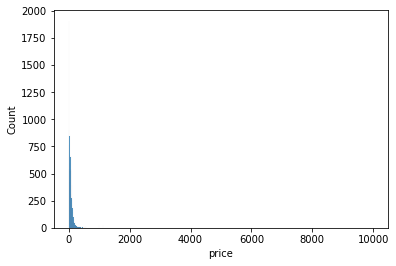

In [ ]:
# 'price' variable distribution
sns.histplot(df.price);

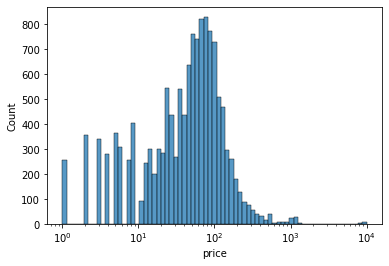

In [ ]:
# 'price' variable log10 distribution
sns.histplot(df.price, log_scale=True);

* Keep listings with prices between 10 and 400:

In [ ]:
df = df[(df.price>=10) & (df.price<=400)]

In [ ]:
df.price.describe().round()

count    11051.0
mean        74.0
std         57.0
min         11.0
25%         35.0
50%         61.0
75%         95.0
max        399.0
Name: price, dtype: float64

* Log transform prices:

In [ ]:
df['price'] = np.log1p(df['price'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


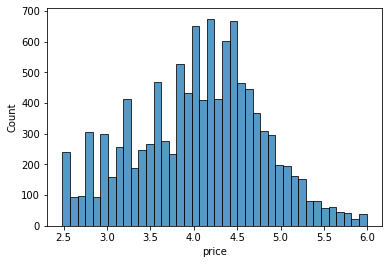

In [ ]:
# 'price' variable distribution
sns.histplot(df.price);

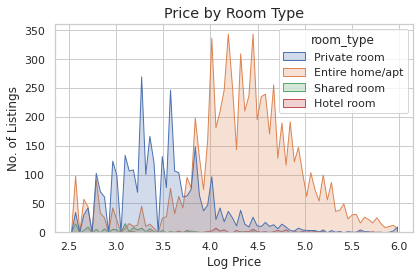

In [ ]:
# 'price' variable distribution by 'room_type'
sns.set_theme(style='whitegrid', rc={'axes.titlesize': 'large'})
fig, ax = plt.subplots()
ax = sns.histplot(df, x='price', bins=80, binrange=(2.5, 6), hue='room_type', element='poly')
plt.xlabel('Log Price')
plt.ylabel('No. of Listings')
plt.title('Price by Room Type')
fig.tight_layout()

### Feature importance: number of reviews ###

In [ ]:
number_of_reviews_price = ['number_of_reviews',
                           'number_of_reviews_ltm',
                           'number_of_reviews_l30d',
                           'price']

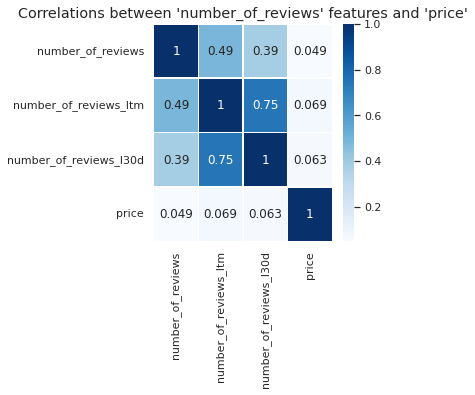

In [ ]:
# Feature correlation: number of reviews
plt.figure(figsize=(4,4))  
sns.heatmap(df[number_of_reviews_price].corr(), annot=True, linewidths=.5, cmap="Blues")
plt.title("Correlations between 'number_of_reviews' features and 'price'")
plt.show()

* We see strong positive correlation between 'number_of_reviews_ltm' and '_l30d' features
* Also, 'number_of_reviews_ltm' has the highest correlation coefficient with regrad to 'price' (0.069)
* Hence we can eliminate 'number_of_reviews' and '_l30d' features

In [ ]:
# Remove 'number_of_reviews' and '_l30d' columns 
df.drop(columns=['number_of_reviews', 'number_of_reviews_l30d'], inplace=True)

### Feature engineering: number of reviews per host ###

In [ ]:
# Reviews per host
df.groupby('host_id').number_of_reviews_ltm.sum().sort_values(ascending=False)

host_id
107335103    2059
107141654    1610
143860194     851
28786243      766
8321213       695
             ... 
48860506        0
48927615        0
49081983        0
49107335        0
422253585       0
Name: number_of_reviews_ltm, Length: 5531, dtype: int64

In [ ]:
# Generate a new column: 'reviews_per_host'
df['reviews_per_host'] = df.groupby('host_id').number_of_reviews_ltm.transform('sum')

In [ ]:
# Remove 'number_of_reviews_ltm' and 'host_id' columns
df.drop(columns=['number_of_reviews_ltm', 'host_id'], inplace=True)

In [ ]:
df.reviews_per_host.corr(df.price).round(3)

0.105

### Feature importance: availability ###

In [ ]:
availability = ['availability_30',
                'availability_60',
                'availability_90',
                'availability_365',
                'price']

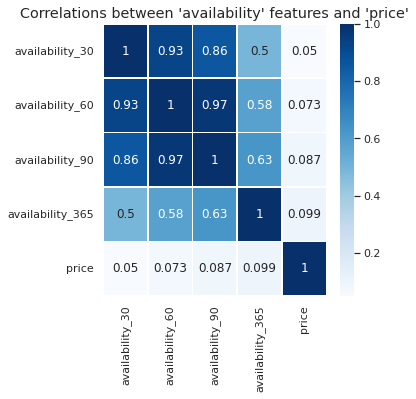

In [ ]:
# Feature correlation: availability
plt.figure(figsize=(5,5))  
sns.heatmap(df[availability].corr(), annot=True, linewidths=.5, cmap="Blues")
plt.title("Correlations between 'availability' features and 'price'")
plt.show()

* We see strong positive (pairwise) correlations between 'availability_30', '_60', and '_90' features;
* And amongst them, 'availability_90' has the highest correlation coefficient with regrad to 'price' (0.087)
* 'availability_365' has the highest correlation coefficient with regrad to 'price' (0.099);
* And a moderate positive correlation coefficient with regrad to 'availability_90' (0.63)
* Hence we can eliminate all 'availability' features except 'availability_365'

In [ ]:
# Remove 'availability_30', '_60', and '_90' columns 
availability_30_60_90 = ['availability_30', 'availability_60', 'availability_90']
df.drop(columns=availability_30_60_90, inplace=True)

### Feature importance: other numerical variables ###

In [ ]:
# We now have 8 numerical variables
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11051 entries, 1 to 18908
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   accommodates                    11051 non-null  int64  
 1   bedrooms                        10263 non-null  float64
 2   price                           11051 non-null  float64
 3   minimum_nights                  11051 non-null  int64  
 4   availability_365                11051 non-null  int64  
 5   calculated_host_listings_count  11051 non-null  int64  
 6   host_is_superhost               11051 non-null  object 
 7   neighbourhood_group_cleansed    11051 non-null  object 
 8   room_type                       11051 non-null  object 
 9   instant_bookable                11051 non-null  object 
 10  host_seniority_days             11051 non-null  int64  
 11  reviews_per_host                11051 non-null  int64  
dtypes: float64(2), int64(6), object(

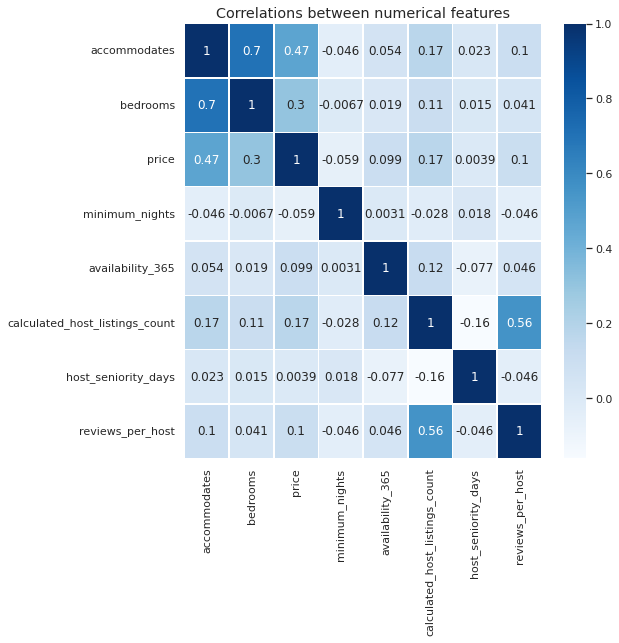

In [ ]:
plt.figure(figsize=(8, 8))  
sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap="Blues")
plt.title('Correlations between numerical features')
plt.show()

#### Correlation between 'accommodates' and 'bedrooms'  features: ####
* Strong positive correlation between the features
* 'accommodates' has the higher correlation coefficient with regrad to 'price' (0.47)
* Hence we can eliminate the 'bedrooms' feature

In [ ]:
# Remove 'bedrooms' column
df.drop(columns='bedrooms', inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11051 entries, 1 to 18908
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   accommodates                    11051 non-null  int64  
 1   price                           11051 non-null  float64
 2   minimum_nights                  11051 non-null  int64  
 3   availability_365                11051 non-null  int64  
 4   calculated_host_listings_count  11051 non-null  int64  
 5   host_is_superhost               11051 non-null  object 
 6   neighbourhood_group_cleansed    11051 non-null  object 
 7   room_type                       11051 non-null  object 
 8   instant_bookable                11051 non-null  object 
 9   host_seniority_days             11051 non-null  int64  
 10  reviews_per_host                11051 non-null  int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 1.0+ MB


### 2.4 Split the dataset into train and test subsets   ###

In [ ]:
df.shape

(11051, 11)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# Check size of dataframes
df_train.shape, df_test.shape

((8840, 11), (2211, 11))

In [ ]:
# Assign 'price' as the target variable
y_train = df_train.price.values
y_test = df_test.price.values

In [ ]:
# Check size of arrays
y_train.shape, y_test.shape

((8840,), (2211,))

In [ ]:
# Remove 'price' column from dataframes
del df_train['price']
del df_test['price']

In [ ]:
# Check size of dataframes
df_train.shape, df_test.shape

((8840, 10), (2211, 10))

### 2.5 One-hot encoding of categorical variables  ###
* **'neighbourhood_group_cleansed'** 

In [ ]:
# All 21 groups are represented in the 'train' dataset
df_train.neighbourhood_group_cleansed.nunique()

21

* **'room_type':** 

In [ ]:
# All four types are represented in the 'train' dataset
df_train.room_type.nunique()

4

* **Use *DictVectorizer* to generate the feature matrix:**

In [ ]:
from sklearn.feature_extraction import DictVectorizer

In [ ]:
# Convert dataframes into lists of dictionaries
train_dict = df_train.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')

In [ ]:
dv = DictVectorizer(sparse=False)

In [ ]:
X_train = dv.fit_transform(train_dict)
X_test = dv.transform(test_dict)

In [ ]:
# We now have 35 features:
dv.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['accommodates',
 'availability_365',
 'calculated_host_listings_count',
 'host_is_superhost=f',
 'host_is_superhost=t',
 'host_seniority_days',
 'instant_bookable=f',
 'instant_bookable=t',
 'minimum_nights',
 'neighbourhood_group_cleansed=Arganzuela',
 'neighbourhood_group_cleansed=Barajas',
 'neighbourhood_group_cleansed=Carabanchel',
 'neighbourhood_group_cleansed=Centro',
 'neighbourhood_group_cleansed=Chamartín',
 'neighbourhood_group_cleansed=Chamberí',
 'neighbourhood_group_cleansed=Ciudad Lineal',
 'neighbourhood_group_cleansed=Fuencarral - El Pardo',
 'neighbourhood_group_cleansed=Hortaleza',
 'neighbourhood_group_cleansed=Latina',
 'neighbourhood_group_cleansed=Moncloa - Aravaca',
 'neighbourhood_group_cleansed=Moratalaz',
 'neighbourhood_group_cleansed=Puente de Vallecas',
 'neighbourhood_group_cleansed=Retiro',
 'neighbourhood_group_cleansed=Salamanca',
 'neighbourhood_group_cleansed=San Blas - Canillejas',
 'neighbourhood_group_cleansed=Tetuán',
 'neighbourhood_group_clea

### 2.6 Train  a linear regression model ###

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Weights
w = model.coef_
w

array([ 8.96580707e-02,  3.71845755e-04,  9.96227422e-04, -3.24806350e-02,
        3.24806350e-02, -1.86347420e-06, -5.20969274e-02,  5.20969274e-02,
       -8.57724096e-04,  5.41210570e-02, -5.76729608e-02, -4.14077096e-02,
        1.61674022e-01,  6.42952497e-02,  1.82089839e-01, -8.94713754e-02,
       -3.24677138e-02, -5.14062404e-03, -1.07434438e-01,  1.13277099e-01,
       -2.31895845e-01, -1.25052994e-01,  1.08181652e-01,  2.07911501e-01,
        6.98116907e-02,  1.50426856e-01, -1.64391517e-01,  6.19150004e-02,
       -4.68745629e-02, -2.71894223e-01, -6.83554097e-05,  3.62386366e-01,
        4.87632734e-01, -1.50047595e-01, -6.99971505e-01])

In [ ]:
dict(zip(dv.get_feature_names(), w.round(5)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{'accommodates': 0.08966,
 'availability_365': 0.00037,
 'calculated_host_listings_count': 0.001,
 'host_is_superhost=f': -0.03248,
 'host_is_superhost=t': 0.03248,
 'host_seniority_days': -0.0,
 'instant_bookable=f': -0.0521,
 'instant_bookable=t': 0.0521,
 'minimum_nights': -0.00086,
 'neighbourhood_group_cleansed=Arganzuela': 0.05412,
 'neighbourhood_group_cleansed=Barajas': -0.05767,
 'neighbourhood_group_cleansed=Carabanchel': -0.04141,
 'neighbourhood_group_cleansed=Centro': 0.16167,
 'neighbourhood_group_cleansed=Chamartín': 0.0643,
 'neighbourhood_group_cleansed=Chamberí': 0.18209,
 'neighbourhood_group_cleansed=Ciudad Lineal': -0.08947,
 'neighbourhood_group_cleansed=Fuencarral - El Pardo': -0.03247,
 'neighbourhood_group_cleansed=Hortaleza': -0.00514,
 'neighbourhood_group_cleansed=Latina': -0.10743,
 'neighbourhood_group_cleansed=Moncloa - Aravaca': 0.11328,
 'neighbourhood_group_cleansed=Moratalaz': -0.2319,
 'neighbourhood_group_cleansed=Puente de Vallecas': -0.12505,
 'ne

In [ ]:
# Bias term
w0 = model.intercept_
w0

3.4101299949847785

In [ ]:
# Base price of a listing in the model
np.expm1(w0)

29.269178845099564

### 2.7 Use the model ###

In [ ]:
from sklearn.metrics import mean_squared_error as mse

In [ ]:
y_train_pred = model.predict(X_train)

In [ ]:
train_mse = mse(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_rmse.round(3)

0.575

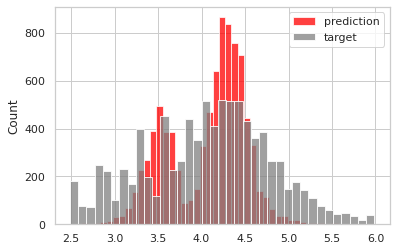

In [ ]:
sns.histplot(y_train_pred, label='prediction', color='red')
sns.histplot(y_train, label='target', color='gray')
plt.legend();

In [ ]:
y_test_pred = model.predict(X_test)

In [ ]:
test_mse = mse(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_rmse.round(3)

0.578

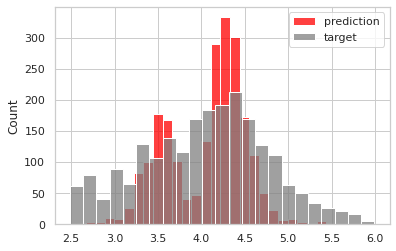

In [ ]:
sns.histplot(y_test_pred, label='prediction', color='red')
sns.histplot(y_test, label='target', color='gray')
plt.legend();

### 2.11 Try regularization: Ridge regression model ###

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
for a in [0, 0.01, 0.1, 1, 10]:
    model = Ridge(alpha=a, random_state=42)
    model.fit(X_train, y_train)
    print('Alpha:', a, 'Weights:', model.coef_, 'Bias term:', model.intercept_)
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mse(y_test, y_pred))
    print('RMSE:', rmse.round(3))
    print('-'*20)

Alpha: 0 Weights: [ 8.96580707e-02  4.33140064e-04  9.67211354e-04 -1.64467343e+11
 -1.64467343e+11 -3.19307306e-06  5.98520570e+10  5.98520570e+10
 -8.05889721e-04 -1.08998120e+09 -1.08998120e+09 -1.08998120e+09
 -1.08998120e+09 -1.08998120e+09 -1.08998120e+09 -1.08998120e+09
 -1.08998120e+09 -1.08998120e+09 -1.08998120e+09 -1.08998120e+09
 -1.08998120e+09 -1.08998120e+09 -1.08998120e+09 -1.08998120e+09
 -1.08998120e+09 -1.08998120e+09 -1.08998120e+09 -1.08998120e+09
 -1.08998121e+09 -1.08998120e+09 -6.69317137e-05 -6.75801765e+10
 -6.75801765e+10 -6.75801765e+10 -6.75801765e+10] Bias term: 173285444150.00592
RMSE: 0.595
--------------------
Alpha: 0.01 Weights: [ 8.96583364e-02  3.71846194e-04  9.96239237e-04 -3.24806194e-02
  3.24806194e-02 -1.86335567e-06 -5.20969567e-02  5.20969567e-02
 -8.57720830e-04  5.41123127e-02 -5.76730517e-02 -4.14137882e-02
  1.61666079e-01  6.42846862e-02  1.82078025e-01 -8.94743578e-02
 -3.24721125e-02 -5.14624215e-03 -1.07436175e-01  1.13264536e-01
 -2